<a href="https://colab.research.google.com/github/claudeshyaka/ml/blob/main/power_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# importing the requests library
import requests
# api-endpoint
URL = "https://api.eia.gov/v2/electricity/rto/daily-region-data/data/\
?api_key=M92dRPibXbr6bpjw4glDgdlTeq1ZVHdY04gSmiHd&frequency=daily&\
data[0]=value&facets[respondent][]=DUK&facets[timezone][]=Eastern&\
facets[type][]=D&facets[type][]=DF&start=2015-06-30&end=2022-12-15&\
sort[0][column]=period&sort[0][direction]=desc&offset=25&length=5442"
# sending get request and saving the response as response object
r = requests.get(url = URL)
# extracting data in json format
data = r.json()
energy_data_duke_carolinas = data["response"]["data"]
print("Number of instances:", len(energy_data_duke_carolinas))
print(energy_data_duke_carolinas[0])
print(energy_data_duke_carolinas[-1])

Number of instances: 5000
{'period': '2022-12-02', 'respondent': 'DUK', 'respondent-name': 'Duke Energy Carolinas', 'type': 'D', 'type-name': 'Demand', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': 316710, 'value-units': 'megawatthours'}
{'period': '2016-01-25', 'respondent': 'DUK', 'respondent-name': 'Duke Energy Carolinas', 'type': 'D', 'type-name': 'Demand', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': 324970, 'value-units': 'megawatthours'}


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

seed = 42

In [4]:
# Load json data into pandas dataframe
df_energy_data_duk_carolinas = \
pd.json_normalize(energy_data_duke_carolinas)
df_energy_data_duk_carolinas.head()

period respondent        respondent-name type  \
0  2022-12-02        DUK  Duke Energy Carolinas    D   
1  2022-12-02        DUK  Duke Energy Carolinas   DF   
2  2022-12-01        DUK  Duke Energy Carolinas    D   
3  2022-12-01        DUK  Duke Energy Carolinas   DF   
4  2022-11-30        DUK  Duke Energy Carolinas    D   

                   type-name timezone timezone-description   value  \
0                     Demand  Eastern              Eastern  316710   
1  Day-ahead demand forecast  Eastern              Eastern  310409   
2                     Demand  Eastern              Eastern  312257   
3  Day-ahead demand forecast  Eastern              Eastern  309103   
4                     Demand  Eastern              Eastern  272322   

     value-units  
0  megawatthours  
1  megawatthours  
2  megawatthours  
3  megawatthours  
4  megawatthours

In [5]:
# Actual Demand
df_energy_data_duk_carolinas_demand = \
df_energy_data_duk_carolinas[df_energy_data_duk_carolinas["type"] == "D"]
df_energy_data_duk_carolinas_demand.head()

period respondent        respondent-name type type-name timezone  \
0  2022-12-02        DUK  Duke Energy Carolinas    D    Demand  Eastern   
2  2022-12-01        DUK  Duke Energy Carolinas    D    Demand  Eastern   
4  2022-11-30        DUK  Duke Energy Carolinas    D    Demand  Eastern   
6  2022-11-29        DUK  Duke Energy Carolinas    D    Demand  Eastern   
8  2022-11-28        DUK  Duke Energy Carolinas    D    Demand  Eastern   

  timezone-description   value    value-units  
0              Eastern  316710  megawatthours  
2              Eastern  312257  megawatthours  
4              Eastern  272322  megawatthours  
6              Eastern  276120  megawatthours  
8              Eastern  257786  megawatthours

In [6]:
# Day ahead demand forecast
df_energy_data_duk_carolinas_demand_day_ahead = \
df_energy_data_duk_carolinas[df_energy_data_duk_carolinas["type"] == "DF"]
df_energy_data_duk_carolinas_demand_day_ahead.head()

period respondent        respondent-name type  \
1  2022-12-02        DUK  Duke Energy Carolinas   DF   
3  2022-12-01        DUK  Duke Energy Carolinas   DF   
5  2022-11-30        DUK  Duke Energy Carolinas   DF   
7  2022-11-29        DUK  Duke Energy Carolinas   DF   
9  2022-11-28        DUK  Duke Energy Carolinas   DF   

                   type-name timezone timezone-description   value  \
1  Day-ahead demand forecast  Eastern              Eastern  310409   
3  Day-ahead demand forecast  Eastern              Eastern  309103   
5  Day-ahead demand forecast  Eastern              Eastern  263916   
7  Day-ahead demand forecast  Eastern              Eastern  274564   
9  Day-ahead demand forecast  Eastern              Eastern  260703   

     value-units  
1  megawatthours  
3  megawatthours  
5  megawatthours  
7  megawatthours  
9  megawatthours

In [7]:
# Sizes of dataframes
df_energy_data_duk_carolinas_demand.shape, \
df_energy_data_duk_carolinas_demand_day_ahead.shape, 

((2504, 9), (2496, 9))

In [8]:
from operator import index
# Load energy data
energy_data = pd.read_csv("./energy_dataset.csv", delimiter=",", \
                          index_col="time")
energy_data.head()

generation biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.0   
2015-01-01 03:00:00+01:00                                 254.0   
2015-01-01 04:00:00+01:00                                 187.0   

                           generation fossil coal-derived gas  \
time                                                            
2015-01-01 00:00:00+01:00                                 0.0   
2015-01-01 01:00:00+01:00                                 0.0   
2015-01-01 02:00:00+01:00                                 0.0   
2015-01-01 03:00:00+01:00                                 0.0   
2015-01-01 04:00:00+01:00                                 0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-01 00:00:00+01:00                 4844.0                       4821.0   
2015-01-01 01:00:00+01:00                 5196.0                       4755.0   
2015-01-01 02:00:00+01:00                 4857.0                       4581.0   
2015-01-01 03:00:00+01:00                 4314.0                       4131.0   
2015-01-01 04:00:00+01:00                 4130.0                       3840.0   

                           generation fossil oil  generation fossil oil shale  \
time                                                                            
2015-01-01 00:00:00+01:00                  162.0                          0.0   
2015-01-01 01:00:00+01:00                  158.0                          0.0   
2015-01-01 02:00:00+01:00                  157.0                          0.0   
2015-01-01 03:00:00+01:00                  160.0                          0.0   
2015-01-01 04:00:00+01:00                  156.0                          0.0   

                           generation fossil peat  generation geothermal  \
time                                                                       
2015-01-01 00:00:00+01:00                     0.0                    0.0   
2015-01-01 01:00:00+01:00                     0.0                    0.0   
2015-01-01 02:00:00+01:00                     0.0                    0.0   
2015-01-01 03:00:00+01:00                     0.0                    0.0   
2015-01-01 04:00:00+01:00                     0.0                    0.0   

                           generation hydro pumped storage aggregated  ...  \
time                                                                   ...   
2015-01-01 00:00:00+01:00                                         NaN  ...   
2015-01-01 01:00:00+01:00                                         NaN  ...   
2015-01-01 02:00:00+01:00                                         NaN  ...   
2015-01-01 03:00:00+01:00                                         NaN  ...   
2015-01-01 04:00:00+01:00                                         NaN  ...   

                           generation waste  generation wind offshore  \
time                                                                    
2015-01-01 00:00:00+01:00             196.0                       0.0   
2015-01-01 01:00:00+01:00             195.0                       0.0   
2015-01-01 02:00:00+01:00             196.0                       0.0   
2015-01-01 03:00:00+01:00             191.0                       0.0   
2015-01-01 04:00:00+01:00             189.0                       0.0   

                           ge

In [9]:
energy_data.shape

(35064, 28)

In [10]:
# Filter energy data from relevant features
energy_data_filters = ['total load forecast', 'total load actual']
energy_data_filtered = energy_data[energy_data_filters]
energy_data_filtered.head()

total load forecast  total load actual
time                                                             
2015-01-01 00:00:00+01:00              26118.0            25385.0
2015-01-01 01:00:00+01:00              24934.0            24382.0
2015-01-01 02:00:00+01:00              23515.0            22734.0
2015-01-01 03:00:00+01:00              22642.0            21286.0
2015-01-01 04:00:00+01:00              21785.0            20264.0

In [11]:
# Print shape of energy
energy_data_filtered.shape

(35064, 2)

In [12]:
# Load weather data
weather_data = pd.read_csv("./weather_features.csv", delimiter=",", \
                           index_col="dt_iso")
weather_data.head()

city_name     temp  temp_min  temp_max  pressure  \
dt_iso                                                                       
2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
dt_iso                                                                        
2015-01-01 00:00:00+01:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00+01:00        77           1        62      0.0      0.0   
2015-01-01 02:00:00+01:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00+01:00        78           0        23      0.0      0.0   
2015-01-01 04:00:00+01:00        78           0        23      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
dt_iso                                                                    
2015-01-01 00:00:00+01:00      0.0           0         800        clear   
2015-01-01 01:00:00+01:00      0.0           0         800        clear   
2015-01-01 02:00:00+01:00      0.0           0         800        clear   
2015-01-01 03:00:00+01:00      0.0           0         800        clear   
2015-01-01 04:00:00+01:00      0.0           0         800        clear   

                          weather_description weather_icon  
dt_iso                                                      
2015-01-01 00:00:00+01:00        sky is clear          01n  
2015-01-01 01:00:00+01:00        sky is clear          01n  
2015-01-01 02:00:00+01:00        sky is clear          01n  
2015-01-01 03:00:00+01:00        sky is clear          01n  
2015-01-01 04:00:00+01:00        sky is clear          01n

In [13]:
# Filter data for relevant features
weather_data_filter = ['city_name', 'temp', 'pressure', 'humidity', \
                       'rain_1h', 'rain_3h', 'snow_3h']
weather_data_filtered = weather_data[weather_data_filter]
weather_data_filtered.head()

city_name     temp  pressure  humidity  rain_1h  \
dt_iso                                                                      
2015-01-01 00:00:00+01:00  Valencia  270.475      1001        77      0.0   
2015-01-01 01:00:00+01:00  Valencia  270.475      1001        77      0.0   
2015-01-01 02:00:00+01:00  Valencia  269.686      1002        78      0.0   
2015-01-01 03:00:00+01:00  Valencia  269.686      1002        78      0.0   
2015-01-01 04:00:00+01:00  Valencia  269.686      1002        78      0.0   

                           rain_3h  snow_3h  
dt_iso                                       
2015-01-01 00:00:00+01:00      0.0      0.0  
2015-01-01 01:00:00+01:00      0.0      0.0  
2015-01-01 02:00:00+01:00      0.0      0.0  
2015-01-01 03:00:00+01:00      0.0      0.0  
2015-01-01 04:00:00+01:00      0.0      0.0

In [14]:
# Get shape of weather data
weather_data_filtered.shape

(178396, 7)

In [15]:
# Destructure data into individual cities
valencia_df = weather_data_filtered[weather_data_filtered['city_name'].str.strip() == 'Valencia']
madrid_df = weather_data_filtered[weather_data_filtered['city_name'].str.strip() == 'Madrid']
bilbao_df = weather_data_filtered[weather_data_filtered['city_name'].str.strip() == 'Bilbao']
barcelona_df = weather_data_filtered[weather_data_filtered['city_name'].str.strip() == 'Barcelona']
seville_df = weather_data_filtered[weather_data_filtered['city_name'].str.strip() == 'Seville']
valencia_df.shape, madrid_df.shape, bilbao_df.shape, barcelona_df.shape, seville_df.shape


((35145, 7), (36267, 7), (35951, 7), (35476, 7), (35557, 7))

In [16]:
# Merge data from individual cities into one dataset
merged_on_time = pd.merge(valencia_df, madrid_df, on=["dt_iso"], how="inner")
merged_on_time = merged_on_time.rename({
    "city_name_x": "city_name_v",
    "temp_x": "temp_v",
    "pressure_x": "pressure_v",
    "humidity_x": "humidity_v",
    "rain_1h_x": "rain_1h_v",
    "rain_3h_x": "rain_3h_v",
    "snow_3h_x": "snow_3h_v",
    "city_name_y": "city_name_m",
    "temp_y": "temp_m",
    "pressure_y": "pressure_m",
    "humidity_y": "humidity_m",
    "rain_1h_y": "rain_1h_m",
    "rain_3h_y": "rain_3h_m",
    "snow_3h_y": "snow_3h_m",
    }, axis=1)

# Merge and rename columns
merged_on_time = pd.merge(merged_on_time, bilbao_df, \
                          on=["dt_iso"], how="inner")
merged_on_time = merged_on_time.rename({
    "city_name": "city_name_b", 
    "temp": "temp_b", 
    "pressure": "pressure_b", 
    "humidity": "humidity_b"}, 
    axis=1)

# Merge and rename columns
merged_on_time = pd.merge(merged_on_time, barcelona_df, \
                          on=["dt_iso"], how="inner")
merged_on_time = merged_on_time.rename({
    "city_name": "city_name_bn", 
    "temp": "temp_bn", 
    "pressure": "pressure_bn", 
    "humidity": "humidity_bn"}, 
    axis=1)

# Merge and rename columns
merged_on_time = pd.merge(merged_on_time, seville_df, \
                          on=["dt_iso"], how="inner")
merged_on_time = merged_on_time.rename({
    "city_name": "city_name_s", 
    "temp": "temp_s", 
    "pressure": "pressure_s", 
    "humidity": "humidity_s"}, 
    axis=1)

# View new dataset
merged_on_time.head()

city_name_v   temp_v  pressure_v  humidity_v  \
dt_iso                                                                   
2015-01-01 00:00:00+01:00    Valencia  270.475        1001          77   
2015-01-01 01:00:00+01:00    Valencia  270.475        1001          77   
2015-01-01 02:00:00+01:00    Valencia  269.686        1002          78   
2015-01-01 03:00:00+01:00    Valencia  269.686        1002          78   
2015-01-01 04:00:00+01:00    Valencia  269.686        1002          78   

                           rain_1h_v  rain_3h_v  snow_3h_v city_name_m  \
dt_iso                                                                   
2015-01-01 00:00:00+01:00        0.0        0.0        0.0      Madrid   
2015-01-01 01:00:00+01:00        0.0        0.0        0.0      Madrid   
2015-01-01 02:00:00+01:00        0.0        0.0        0.0      Madrid   
2015-01-01 03:00:00+01:00        0.0        0.0        0.0      Madrid   
2015-01-01 04:00:00+01:00        0.0        0.0        0.0      Madrid   

                            temp_m  pressure_m  ...  rain_1h_y  rain_3h_y  \
dt_iso                                          ...                         
2015-01-01 00:00:00+01:00  267.325         971  ...        0.0        0.0   
2015-01-01 01:00:00+01:00  267.325         971  ...        0.0        0.0   
2015-01-01 02:00:00+01:00  266.186         971  ...        0.0        0.0   
2015-01-01 03:00:00+01:00  266.186         971  ...        0.0        0.0   
2015-01-01 04:00:00+01:00  266.186         971  ...        0.0        0.0   

                           snow_3h_y  city_name_s   temp_s  pressure_s  \
dt_iso                                                                   
2015-01-01 00:00:00+01:00        0.0      Seville  273.375        1039   
2015-01-01 01:00:00+01:00        0.0      Seville  273.375        1039   
2015-01-01 02:00:00+01:00        0.0      Seville  274.086        1039   
2015-01-01 03:00:00+01:00        0.0      Seville  274.086        1039   
2015-01-01 04:00:00+01:00        0.0      Seville  274.086        1039   

                           humidity_s  rain_1h  rain_3h  snow_3h  
dt_iso                                                            
2015-01-01 00:00:00+01:00          75      0.0      0.0      0.0  
2015-01-01 01:00:00+01:00          75      0.0      0.0      0.0  
2015-01-01 02:00:00+01:00          71      0.0      0.0      0.0  
2015-01-01 03:00:00+01:00          71      0.0      0.0      0.0  
2015-01-01 04:00:00+01:00          71      0.0      0.0      0.0  

[5 rows x 35 columns]

In [17]:
# Filters to average over
temp_cols = ['temp_v', 'temp_m', 'temp_b', 'temp_bn', 'temp_s']
pressure_cols = ['pressure_v', 'pressure_m', 'pressure_b', \
                 'pressure_bn', 'pressure_s']
humidity_cols = ['humidity_v', 'humidity_m', 'humidity_b', \
                 'humidity_bn', 'humidity_s']
rain1h_cols = ['rain1h_v', 'rain1h_m', 'rain1h_b', 'rain1h_bn', \
               'rain1h_s']
rain3h_cols = ['rain3h_v', 'rain3h_m', 'rain3h_b', 'rain3h_bn', \
               'rain3h_s']
snow3h_cols = ['snow3h_v', 'snow3h_m', 'snow3h_b', 'snow3h_bn', \
               'snow3h_s']

# Compute mean for all features to build a df for overall cities
merged_on_time['avg_temp'] = merged_on_time[temp_cols].mean(axis=1)
merged_on_time['avg_pressure'] = merged_on_time[pressure_cols].mean(axis=1)
merged_on_time['avg_humidity'] = merged_on_time[humidity_cols].mean(axis=1)
merged_on_time['avg_rain1h'] = merged_on_time[humidity_cols].mean(axis=1)
merged_on_time['avg_rain3h'] = merged_on_time[humidity_cols].mean(axis=1)
merged_on_time['avg_snow3h'] = merged_on_time[humidity_cols].mean(axis=1)
merged_on_time.shape

(38568, 41)

In [18]:
merged_on_time.head()

city_name_v   temp_v  pressure_v  humidity_v  \
dt_iso                                                                   
2015-01-01 00:00:00+01:00    Valencia  270.475        1001          77   
2015-01-01 01:00:00+01:00    Valencia  270.475        1001          77   
2015-01-01 02:00:00+01:00    Valencia  269.686        1002          78   
2015-01-01 03:00:00+01:00    Valencia  269.686        1002          78   
2015-01-01 04:00:00+01:00    Valencia  269.686        1002          78   

                           rain_1h_v  rain_3h_v  snow_3h_v city_name_m  \
dt_iso                                                                   
2015-01-01 00:00:00+01:00        0.0        0.0        0.0      Madrid   
2015-01-01 01:00:00+01:00        0.0        0.0        0.0      Madrid   
2015-01-01 02:00:00+01:00        0.0        0.0        0.0      Madrid   
2015-01-01 03:00:00+01:00        0.0        0.0        0.0      Madrid   
2015-01-01 04:00:00+01:00        0.0        0.0        0.0      Madrid   

                            temp_m  pressure_m  ...  humidity_s  rain_1h  \
dt_iso                                          ...                        
2015-01-01 00:00:00+01:00  267.325         971  ...          75      0.0   
2015-01-01 01:00:00+01:00  267.325         971  ...          75      0.0   
2015-01-01 02:00:00+01:00  266.186         971  ...          71      0.0   
2015-01-01 03:00:00+01:00  266.186         971  ...          71      0.0   
2015-01-01 04:00:00+01:00  266.186         971  ...          71      0.0   

                           rain_3h  snow_3h    avg_temp  avg_pressure  \
dt_iso                                                                  
2015-01-01 00:00:00+01:00      0.0      0.0  272.491463        1016.4   
2015-01-01 01:00:00+01:00      0.0      0.0  272.512700        1016.2   
2015-01-01 02:00:00+01:00      0.0      0.0  272.099137        1016.8   
2015-01-01 03:00:00+01:00      0.0      0.0  272.089469        1016.6   
2015-01-01 04:00:00+01:00      0.0      0.0  272.145900        1016.6   

                           avg_humidity  avg_rain1h  avg_rain3h  avg_snow3h  
dt_iso                                                                       
2015-01-01 00:00:00+01:00          82.4        82.4        82.4        82.4  
2015-01-01 01:00:00+01:00          82.4        82.4        82.4        82.4  
2015-01-01 02:00:00+01:00          82.0        82.0        82.0        82.0  
2015-01-01 03:00:00+01:00          82.0        82.0        82.0        82.0  
2015-01-01 04:00:00+01:00          82.0        82.0        82.0        82.0  

[5 rows x 41 columns]

In [19]:
# Filter the mean columns values
new_filter = ['avg_temp', 'avg_pressure', 'avg_humidity', 'avg_rain1h', \
              'avg_rain3h', 'avg_snow3h']
weather_data_filtered = merged_on_time[new_filter]

# Rename columns for more descriptive names
weather_data_filtered = weather_data_filtered.rename(
    {"avg_temp": "Average temperature in K", 
     "avg_pressure": "Average pressure in hPa", 
     "avg_humidity": "Average humidity in %",
     "avg_rain1h":"Average rain in last 1 hour in mm",
     "avg_rain3h":"Average rain in last 3 hours in mm",
     "avg_snow3h":"Average snow in last 3 hours in mm"
     }, axis=1)
weather_data_filtered.index.names = ['time']
weather_data_filtered.columns

Index(['Average temperature in K', 'Average pressure in hPa',
       'Average humidity in %', 'Average rain in last 1 hour in mm',
       'Average rain in last 3 hours in mm',
       'Average snow in last 3 hours in mm'],
      dtype='object')

In [20]:
weather_data_filtered.head()

Average temperature in K  Average pressure in hPa  \
time                                                                           
2015-01-01 00:00:00+01:00                272.491463                   1016.4   
2015-01-01 01:00:00+01:00                272.512700                   1016.2   
2015-01-01 02:00:00+01:00                272.099137                   1016.8   
2015-01-01 03:00:00+01:00                272.089469                   1016.6   
2015-01-01 04:00:00+01:00                272.145900                   1016.6   

                           Average humidity in %  \
time                                               
2015-01-01 00:00:00+01:00                   82.4   
2015-01-01 01:00:00+01:00                   82.4   
2015-01-01 02:00:00+01:00                   82.0   
2015-01-01 03:00:00+01:00                   82.0   
2015-01-01 04:00:00+01:00                   82.0   

                           Average rain in last 1 hour in mm  \
time                                                           
2015-01-01 00:00:00+01:00                               82.4   
2015-01-01 01:00:00+01:00                               82.4   
2015-01-01 02:00:00+01:00                               82.0   
2015-01-01 03:00:00+01:00                               82.0   
2015-01-01 04:00:00+01:00                               82.0   

                           Average rain in last 3 hours in mm  \
time                                                            
2015-01-01 00:00:00+01:00                                82.4   
2015-01-01 01:00:00+01:00                                82.4   
2015-01-01 02:00:00+01:00                                82.0   
2015-01-01 03:00:00+01:00                                82.0   
2015-01-01 04:00:00+01:00                                82.0   

                           Average snow in last 3 hours in mm  
time                                                           
2015-01-01 00:00:00+01:00                                82.4  
2015-01-01 01:00:00+01:00                                82.4  
2015-01-01 02:00:00+01:00                                82.0  
2015-01-01 03:00:00+01:00                                82.0  
2015-01-01 04:00:00+01:00                                82.0

In [21]:
# merge load and weather data
df = pd.merge(weather_data_filtered, energy_data_filtered, on="time", \
              how="inner")

# Check for any missing values function
df.isna().any()

Average temperature in K              False
Average pressure in hPa               False
Average humidity in %                 False
Average rain in last 1 hour in mm     False
Average rain in last 3 hours in mm    False
Average snow in last 3 hours in mm    False
total load forecast                   False
total load actual                      True
dtype: bool

In [22]:
# Fill missing values by linear interpolation
df = df.interpolate(method='linear', limit_direction='forward')
# recheck for missing values
df.isna().any()

Average temperature in K              False
Average pressure in hPa               False
Average humidity in %                 False
Average rain in last 1 hour in mm     False
Average rain in last 3 hours in mm    False
Average snow in last 3 hours in mm    False
total load forecast                   False
total load actual                     False
dtype: bool

In [23]:
# View current state of the complete dataset
df.head()

Average temperature in K  Average pressure in hPa  \
time                                                                           
2015-01-01 00:00:00+01:00                272.491463                   1016.4   
2015-01-01 01:00:00+01:00                272.512700                   1016.2   
2015-01-01 02:00:00+01:00                272.099137                   1016.8   
2015-01-01 03:00:00+01:00                272.089469                   1016.6   
2015-01-01 04:00:00+01:00                272.145900                   1016.6   

                           Average humidity in %  \
time                                               
2015-01-01 00:00:00+01:00                   82.4   
2015-01-01 01:00:00+01:00                   82.4   
2015-01-01 02:00:00+01:00                   82.0   
2015-01-01 03:00:00+01:00                   82.0   
2015-01-01 04:00:00+01:00                   82.0   

                           Average rain in last 1 hour in mm  \
time                                                           
2015-01-01 00:00:00+01:00                               82.4   
2015-01-01 01:00:00+01:00                               82.4   
2015-01-01 02:00:00+01:00                               82.0   
2015-01-01 03:00:00+01:00                               82.0   
2015-01-01 04:00:00+01:00                               82.0   

                           Average rain in last 3 hours in mm  \
time                                                            
2015-01-01 00:00:00+01:00                                82.4   
2015-01-01 01:00:00+01:00                                82.4   
2015-01-01 02:00:00+01:00                                82.0   
2015-01-01 03:00:00+01:00                                82.0   
2015-01-01 04:00:00+01:00                                82.0   

                           Average snow in last 3 hours in mm  \
time                                                            
2015-01-01 00:00:00+01:00                                82.4   
2015-01-01 01:00:00+01:00                                82.4   
2015-01-01 02:00:00+01:00                                82.0   
2015-01-01 03:00:00+01:00                                82.0   
2015-01-01 04:00:00+01:00                                82.0   

                           total load forecast  total load actual  
time                                                               
2015-01-01 00:00:00+01:00              26118.0            25385.0  
2015-01-01 01:00:00+01:00              24934.0            24382.0  
2015-01-01 02:00:00+01:00              23515.0            22734.0  
2015-01-01 03:00:00+01:00              22642.0            21286.0  
2015-01-01 04:00:00+01:00              21785.0            20264.0

In [24]:
df.tail()

Average temperature in K  Average pressure in hPa  \
time                                                                           
2018-12-31 19:00:00+01:00                   284.470                   1029.2   
2018-12-31 20:00:00+01:00                   282.294                   1030.0   
2018-12-31 21:00:00+01:00                   280.850                   1029.8   
2018-12-31 22:00:00+01:00                   279.718                   1030.2   
2018-12-31 23:00:00+01:00                   278.798                   1030.2   

                           Average humidity in %  \
time                                               
2018-12-31 19:00:00+01:00                   73.6   
2018-12-31 20:00:00+01:00                   68.0   
2018-12-31 21:00:00+01:00                   71.4   
2018-12-31 22:00:00+01:00                   70.0   
2018-12-31 23:00:00+01:00                   82.4   

                           Average rain in last 1 hour in mm  \
time                                                           
2018-12-31 19:00:00+01:00                               73.6   
2018-12-31 20:00:00+01:00                               68.0   
2018-12-31 21:00:00+01:00                               71.4   
2018-12-31 22:00:00+01:00                               70.0   
2018-12-31 23:00:00+01:00                               82.4   

                           Average rain in last 3 hours in mm  \
time                                                            
2018-12-31 19:00:00+01:00                                73.6   
2018-12-31 20:00:00+01:00                                68.0   
2018-12-31 21:00:00+01:00                                71.4   
2018-12-31 22:00:00+01:00                                70.0   
2018-12-31 23:00:00+01:00                                82.4   

                           Average snow in last 3 hours in mm  \
time                                                            
2018-12-31 19:00:00+01:00                                73.6   
2018-12-31 20:00:00+01:00                                68.0   
2018-12-31 21:00:00+01:00                                71.4   
2018-12-31 22:00:00+01:00                                70.0   
2018-12-31 23:00:00+01:00                                82.4   

                           total load forecast  total load actual  
time                                                               
2018-12-31 19:00:00+01:00              30619.0            30653.0  
2018-12-31 20:00:00+01:00              29932.0            29735.0  
2018-12-31 21:00:00+01:00              27903.0            28071.0  
2018-12-31 22:00:00+01:00              25450.0            25801.0  
2018-12-31 23:00:00+01:00              24424.0            24455.0

In [25]:
# Filter dataset for features
feature = ["Average temperature in K", "Average pressure in hPa", \
           "Average humidity in %", "Average rain in last 1 hour in mm", \
           "Average rain in last 3 hours in mm", \
           "Average snow in last 3 hours in mm", "total load actual"]
df_dataset = df[feature]
df_dataset.head()

Average temperature in K  Average pressure in hPa  \
time                                                                           
2015-01-01 00:00:00+01:00                272.491463                   1016.4   
2015-01-01 01:00:00+01:00                272.512700                   1016.2   
2015-01-01 02:00:00+01:00                272.099137                   1016.8   
2015-01-01 03:00:00+01:00                272.089469                   1016.6   
2015-01-01 04:00:00+01:00                272.145900                   1016.6   

                           Average humidity in %  \
time                                               
2015-01-01 00:00:00+01:00                   82.4   
2015-01-01 01:00:00+01:00                   82.4   
2015-01-01 02:00:00+01:00                   82.0   
2015-01-01 03:00:00+01:00                   82.0   
2015-01-01 04:00:00+01:00                   82.0   

                           Average rain in last 1 hour in mm  \
time                                                           
2015-01-01 00:00:00+01:00                               82.4   
2015-01-01 01:00:00+01:00                               82.4   
2015-01-01 02:00:00+01:00                               82.0   
2015-01-01 03:00:00+01:00                               82.0   
2015-01-01 04:00:00+01:00                               82.0   

                           Average rain in last 3 hours in mm  \
time                                                            
2015-01-01 00:00:00+01:00                                82.4   
2015-01-01 01:00:00+01:00                                82.4   
2015-01-01 02:00:00+01:00                                82.0   
2015-01-01 03:00:00+01:00                                82.0   
2015-01-01 04:00:00+01:00                                82.0   

                           Average snow in last 3 hours in mm  \
time                                                            
2015-01-01 00:00:00+01:00                                82.4   
2015-01-01 01:00:00+01:00                                82.4   
2015-01-01 02:00:00+01:00                                82.0   
2015-01-01 03:00:00+01:00                                82.0   
2015-01-01 04:00:00+01:00                                82.0   

                           total load actual  
time                                          
2015-01-01 00:00:00+01:00            25385.0  
2015-01-01 01:00:00+01:00            24382.0  
2015-01-01 02:00:00+01:00            22734.0  
2015-01-01 03:00:00+01:00            21286.0  
2015-01-01 04:00:00+01:00            20264.0

In [26]:
df_dataset.shape

(38568, 7)

In [27]:
# Obtain values from pd frame
data = df_dataset.values
batch_svr = data[:5000, :]
data.shape

(38568, 7)

In [28]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

cols_to_plot = ["Average temperature in K"]
fig = px.line(df[cols_to_plot], labels=dict(
    created_at="Date", value="Features", variable="Sensor"
))
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

## Using Classical Machine Learning

In [29]:
import time
# Train LR to compare with the SVR results
def TrainLRModels(data):

    # Split the data in train and test set
    data_train, data_test = train_test_split(data, train_size=0.8, test_size=0.2, random_state=seed)

    # Apply the MinMaxScaler to the Datasets
    sc = MinMaxScaler()
    data_train_scaled = sc.fit_transform(data_train)
    data_test_scaled = sc.transform(data_test)
    
    n_of_feature = data.shape[1]-1

    # Get the training feature and labels
    X_train, Y_train = data_train_scaled[:, :n_of_feature], data_train_scaled[:, n_of_feature]

    # Get the testing features and labels
    X_test, Y_test = data_test_scaled[:, :n_of_feature], data_test_scaled[:, n_of_feature]

    # Ridge regression model
    model = GridSearchCV(
        Ridge(),
        param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3]},
    )
    t0 = time.time()
    model.fit(X_train, Y_train)
    rr_fit = time.time() - t0
    estimator = model.best_estimator_
    Y_pred = estimator.predict(X_test)
    print(f"Best RR with params: {model.best_params_} and R2 score: {model.best_score_:.3f}")
    print("Mean Squared Error from RR Model:", mean_squared_error(Y_test, Y_pred))
    print("RR complexity and bandwidth selected and model fitted in %.3f s" % rr_fit)

In [30]:
import time
# Train SVR models without using PCA
def TrainSVRModel(data):

    # Split the data in train and test set
    data_train, data_test = train_test_split(data, train_size=0.8, test_size=0.2, random_state=seed)

    # Apply the MinMaxScaler to the Datasets
    sc = MinMaxScaler()
    data_train_scaled = sc.fit_transform(data_train)
    data_test_scaled = sc.transform(data_test)
    
    n_of_feature = data.shape[1]-1

    # Get the training feature and labels
    X_train, Y_train = data_train_scaled[:, :n_of_feature], data_train_scaled[:, n_of_feature]

    # Get the testing features and labels
    X_test, Y_test = data_test_scaled[:, :n_of_feature], data_test_scaled[:, n_of_feature]

    # Support Vector Regression model
    model = GridSearchCV(
        SVR(kernel="rbf", gamma=0.1),
        param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
    )
    t0 = time.time()
    model.fit(X_train, Y_train)
    svr_fit = time.time() - t0
    estimator = model.best_estimator_
    Y_pred = estimator.predict(X_test)
    print(f"Best SVR with params: {model.best_params_} and R2 score: {model.best_score_:.3f}")
    print("Mean Squared Error from SVR Model:", mean_squared_error(Y_test, Y_pred))
    print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

In [31]:
# Train a linear regression model.
TrainLRModels(data)

Best RR with params: {'alpha': 1.0} and R2 score: 0.120
Mean Squared Error from RR Model: 0.035647984691320446
RR complexity and bandwidth selected and model fitted in 0.561 s


In [32]:
# Train a Support Vector Regression model
TrainSVRModel(batch_svr)

Best SVR with params: {'C': 1.0, 'gamma': 10.0} and R2 score: 0.234
Mean Squared Error from SVR Model: 0.03730149595026273
SVR complexity and bandwidth selected and model fitted in 628.587 s


## Using Neural Networks

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(seed)

In [34]:
# Generate random indices for training and validation data.
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

# shuffled_indices = torch.randperm(n_samples)

# train_indices = shuffled_indices[:-n_val]
# val_indices = shuffled_indices[-n_val:]

# Filter the train and val subsets from the dataset
# print("Number of training samples:", len(train_indices))
# print("Number of validation samples:", len(val_indices))
df_train_data = df_dataset.iloc[:-n_val]
df_val_data = df_dataset.iloc[-n_val:]
print("Number of training samples:", df_train_data.shape)
print("Number of validation samples:", df_val_data.shape)

Number of training samples: (30855, 7)
Number of validation samples: (7713, 7)


In [35]:
df_train_data

Average temperature in K  Average pressure in hPa  \
time                                                                           
2015-01-01 00:00:00+01:00                272.491463                   1016.4   
2015-01-01 01:00:00+01:00                272.512700                   1016.2   
2015-01-01 02:00:00+01:00                272.099137                   1016.8   
2015-01-01 03:00:00+01:00                272.089469                   1016.6   
2015-01-01 04:00:00+01:00                272.145900                   1016.6   
...                                             ...                      ...   
2018-03-20 11:00:00+01:00                280.114000                   1013.0   
2018-03-20 12:00:00+01:00                281.048000                   1013.4   
2018-03-20 13:00:00+01:00                282.008000                   1013.8   
2018-03-20 14:00:00+01:00                282.732000                   1014.2   
2018-03-20 15:00:00+01:00                282.808000                   1014.6   

                           Average humidity in %  \
time                                               
2015-01-01 00:00:00+01:00                   82.4   
2015-01-01 01:00:00+01:00                   82.4   
2015-01-01 02:00:00+01:00                   82.0   
2015-01-01 03:00:00+01:00                   82.0   
2015-01-01 04:00:00+01:00                   82.0   
...                                          ...   
2018-03-20 11:00:00+01:00                   67.2   
2018-03-20 12:00:00+01:00                   57.0   
2018-03-20 13:00:00+01:00                   52.6   
2018-03-20 14:00:00+01:00                   49.4   
2018-03-20 15:00:00+01:00                   49.4   

                           Average rain in last 1 hour in mm  \
time                                                           
2015-01-01 00:00:00+01:00                               82.4   
2015-01-01 01:00:00+01:00                               82.4   
2015-01-01 02:00:00+01:00                               82.0   
2015-01-01 03:00:00+01:00                               82.0   
2015-01-01 04:00:00+01:00                               82.0   
...                                                      ...   
2018-03-20 11:00:00+01:00                               67.2   
2018-03-20 12:00:00+01:00                               57.0   
2018-03-20 13:00:00+01:00                               52.6   
2018-03-20 14:00:00+01:00                               49.4   
2018-03-20 15:00:00+01:00                               49.4   

                           Average rain in last 3 hours in mm  \
time                                                            
2015-01-01 00:00:00+01:00                                82.4   
2015-01-01 01:00:00+01:00                                82.4   
2015-01-01 02:00:00+01:00                                82.0   
2015-01-01 03:00:00+01:00                                82.0   
2015-01-01 04:00:00+01:00                                82.0   
...                                                       ...   
2018-03-20 11:00:00+01:00                                67.2   
2018-03-20 12:00:00+01:00                                57.0   
2018-03-20 13:00:00+01:00                                52.6   
2018-03-20 14:00:00+01:00                                49.4   
2018-03-20 15:00:00+01:00                                49.4   

                           Average snow in last 3 hours in mm  \
time                                                            
2015-01-01 00:00:00+01:00                                82.4   
2015-01-01 01:00:00+01:00                                82.4   
2015-01-01 02:00:00+01:00                                82.0   
2015-01-01 03:00:00+01:00                                82.0   
2015-01-01 04:00:00+01:00                                82.0   
...                                                       ...   
2018-03-20 11:00:00+01:00                                67.2   
2018-03-20 12:00:00+01:00                    

In [36]:
# Normalize the train and val subsets
target_mean = df_train_data["total load actual"].mean()
target_std = df_train_data["total load actual"].std()
print(target_mean, target_std)
for c in df_train_data.columns:
  mean = df_train_data[c].mean()
  std = df_train_data[c].std()
  df_train_data[c] = (df_train_data[c] - mean) / std
  df_val_data[c] = (df_val_data[c] - mean) / std

28715.937157672986 4612.884569909277


<ipython-input-36-1bde7a894bc4>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-36-1bde7a894bc4>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
# Transform data to a tensors
t_train_data = torch.tensor(df_train_data.values, dtype=torch.float32)
t_val_data = torch.tensor(df_val_data.values, dtype=torch.float32)

# Filter features and targets for training and validation.
t_un_train = t_train_data[:, :-1]
t_cn_train = t_train_data[:, -1].unsqueeze(1)

t_un_val = t_val_data[:, :-1]
t_cn_val = t_val_data[:, -1].unsqueeze(1)
t_un_train.shape, t_cn_train.shape, t_un_val.shape, t_cn_val.shape

(torch.Size([30855, 6]),
 torch.Size([30855, 1]),
 torch.Size([7713, 6]),
 torch.Size([7713, 1]))

In [38]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear_1', nn.Linear(6, 60)),
    ('hidden_activation_1', nn.ReLU()),
    ('hidden_linear_2', nn.Linear(60, 200)),
    ('hidden_activation_2', nn.ReLU()),
    ('output_linear_3', nn.Linear(200, 20)),
    ('hidden_activation_3', nn.ReLU()),
    ('output_linear', nn.Linear(20, 1))
]))

In [39]:
import time

loss_train_list = []
loss_val_list = []
epochs_list = []

def training_loop(
    n_epochs, optimizer, model, loss_fn, 
    t_u_train, t_u_val, t_c_train, t_c_val
    ):
    
    duration = []
    training_start_time = time.time()

    for epoch in range(1, n_epochs+1):
        
        t0 = time.time()

        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        with torch.no_grad():
            t_p_val = model(t_u_val)
            loss_val = loss_fn(t_p_val, t_c_val)
            assert loss_val.requires_grad == False

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        duration.append(time.time() - t0)

        if epoch == 1 or epoch % 50 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}, Time(s) {np.mean(duration):.5f}")
            loss_train_list.append(loss_train.item())
            loss_val_list.append(loss_val.item())
            epochs_list.append(epoch)
    print(f'Training finished, took {time.time() - training_start_time:.5f} seconds')

# Computing the Model Size
def compute_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.4f}MB'.format(size_all_mb))

In [40]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 500, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_cn_train,
    t_c_val = t_cn_val)
    
# Computing the Model Size
compute_model_size(seq_model)

Epoch 1, Training loss 0.9945, Validation loss 0.9687, Time(s) 0.33300
Epoch 50, Training loss 0.9858, Validation loss 0.9579, Time(s) 0.15327
Epoch 100, Training loss 0.9780, Validation loss 0.9480, Time(s) 0.13847
Epoch 150, Training loss 0.9708, Validation loss 0.9390, Time(s) 0.13392
Epoch 200, Training loss 0.9643, Validation loss 0.9307, Time(s) 0.13172
Epoch 250, Training loss 0.9583, Validation loss 0.9230, Time(s) 0.13023
Epoch 300, Training loss 0.9528, Validation loss 0.9157, Time(s) 0.12931
Epoch 350, Training loss 0.9476, Validation loss 0.9089, Time(s) 0.12852
Epoch 400, Training loss 0.9427, Validation loss 0.9023, Time(s) 0.12799
Epoch 450, Training loss 0.9381, Validation loss 0.8960, Time(s) 0.12747
Epoch 500, Training loss 0.9338, Validation loss 0.8901, Time(s) 0.12704
Training finished, took 63.52562 seconds
model size: 0.0636MB


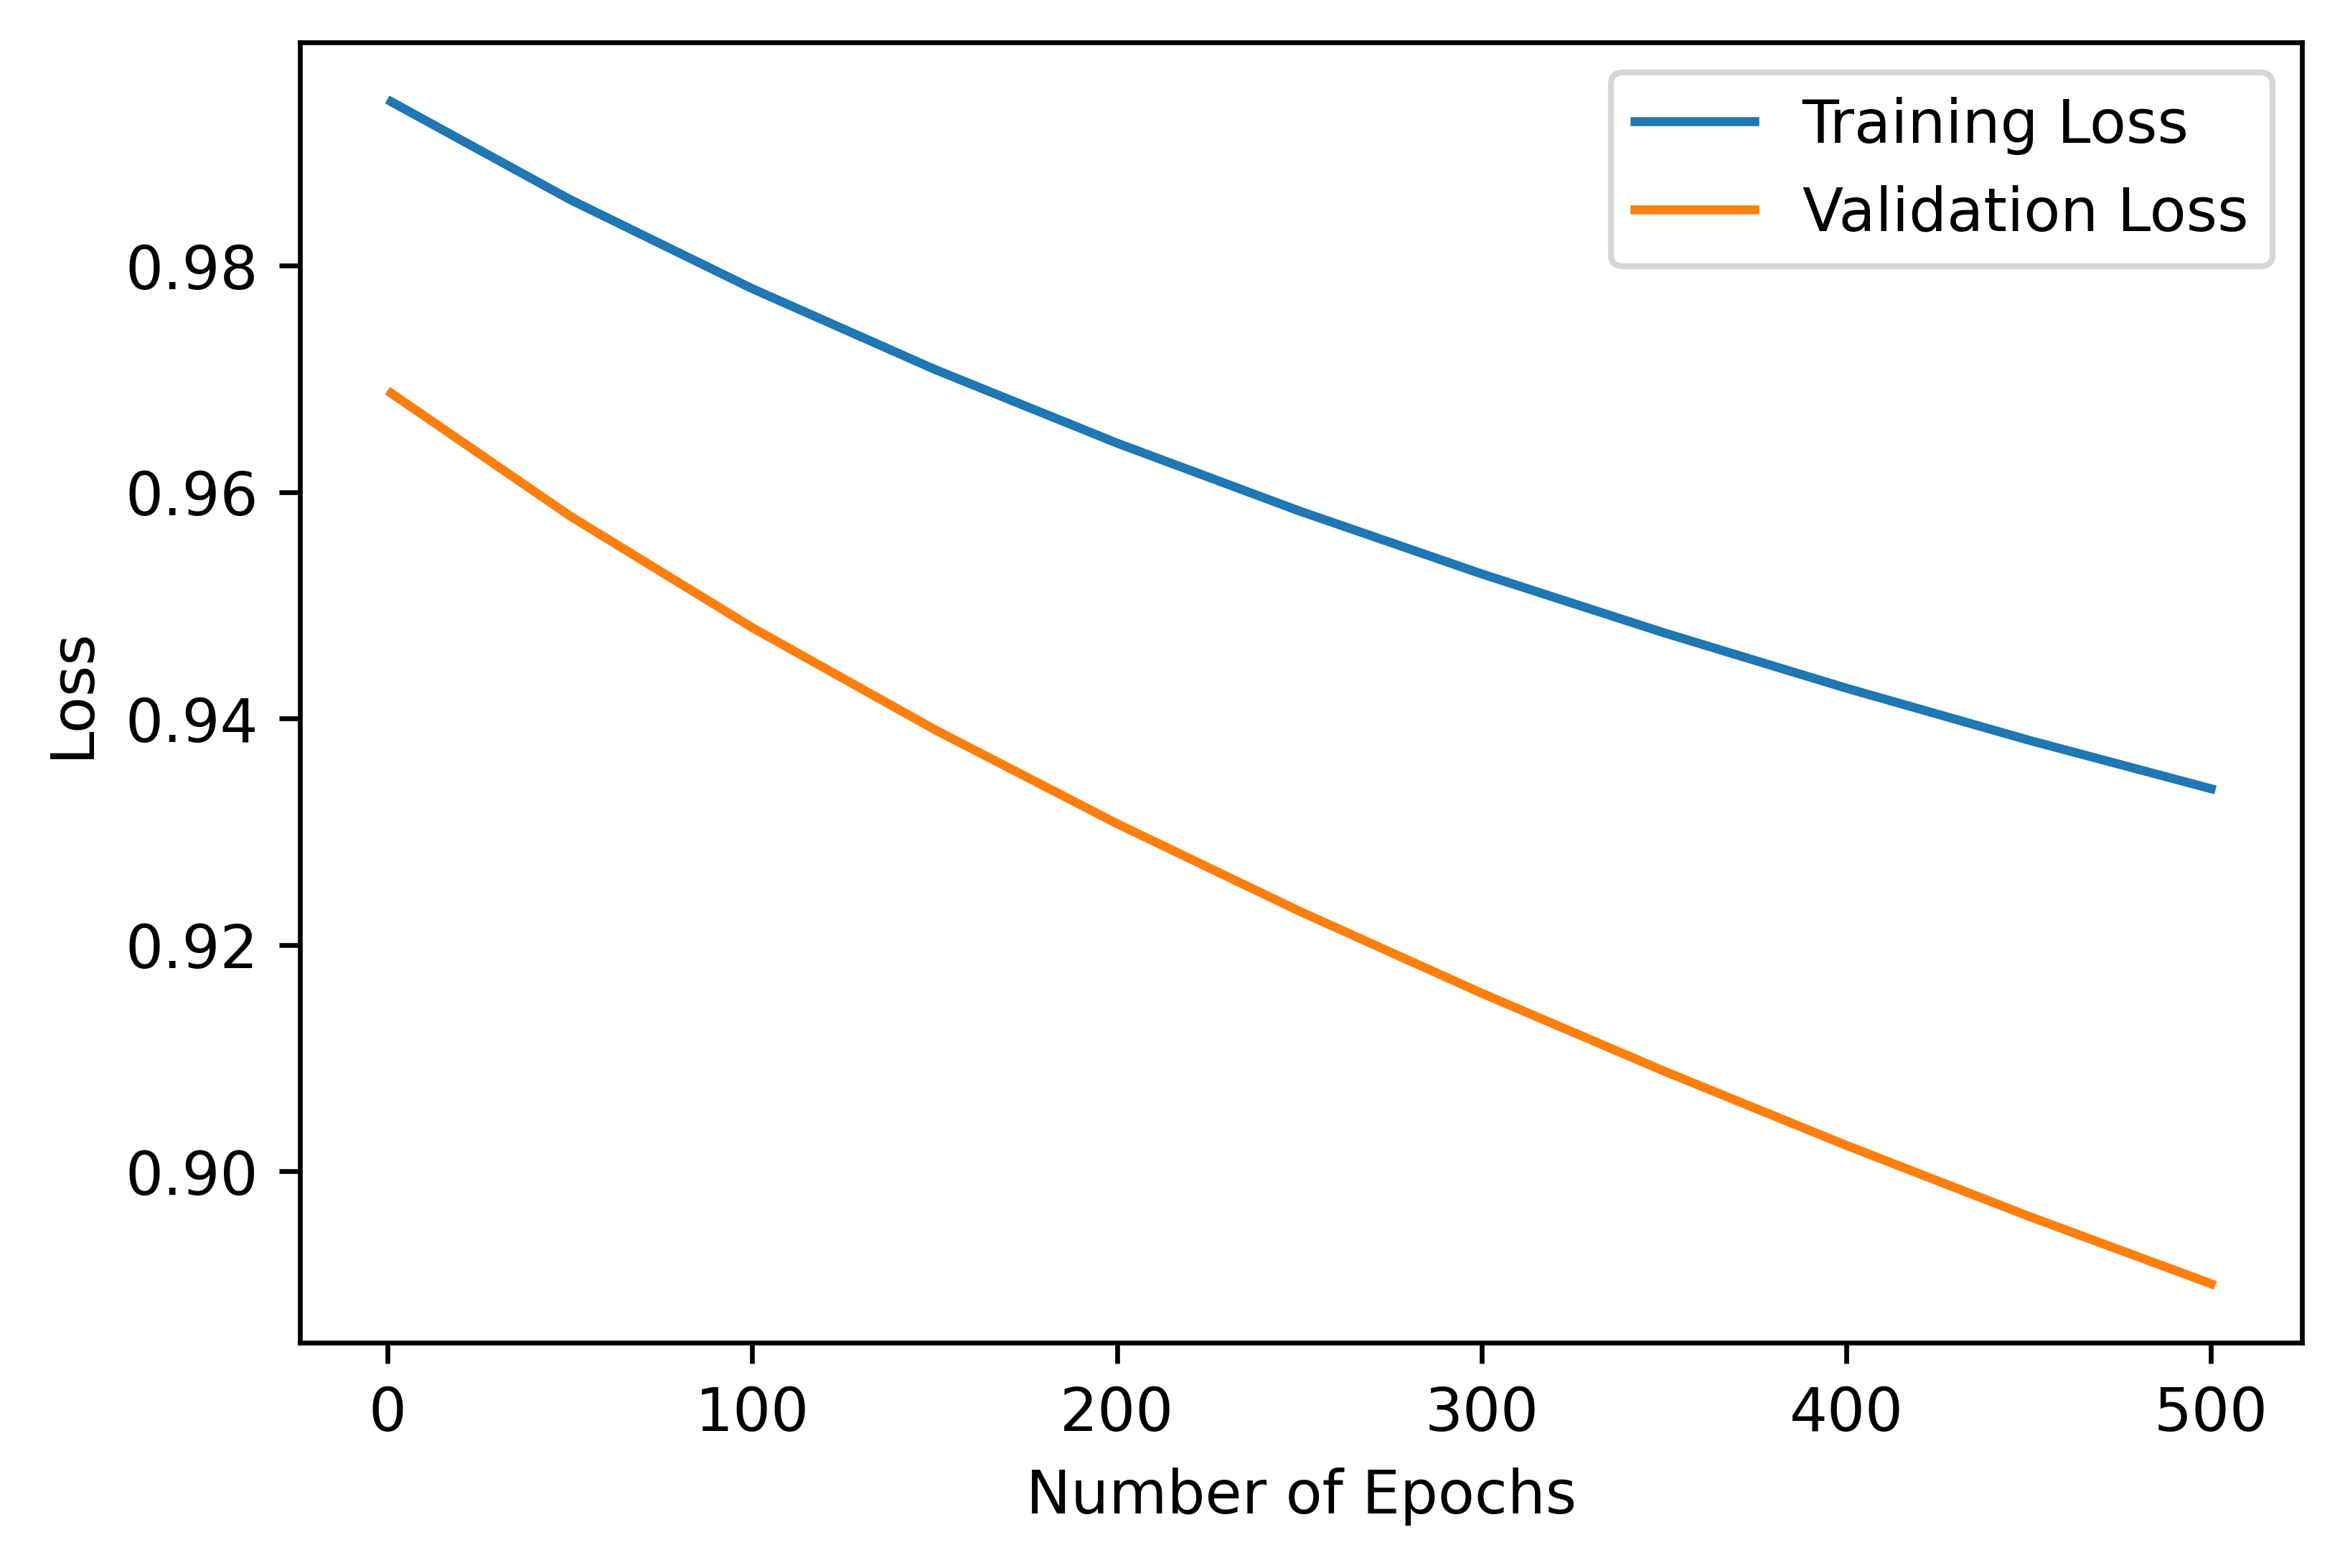

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.plot(epochs_list, loss_train_list, label="Training Loss")
plt.plot(epochs_list, loss_val_list, label="Validation Loss")
plt.legend()
plt.savefig("./loss_fun_1", format="png")

In [42]:
# Reinitialize variables 
optimizer = None
seq_model = None
loss_train_list = []
loss_val_list = []
epochs_list = []

In [43]:
# Neural Net of 5 hidden layers.
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear_1', nn.Linear(6, 9)),
    ('hidden_activation_1', nn.ReLU()),
    ('hidden_linear_2', nn.Linear(9, 81)),
    ('hidden_activation_2', nn.ReLU()),
    ('hidden_linear_3', nn.Linear(81, 500)),
    ('hidden_activation_3', nn.ReLU()),
    ('hidden_linear_4', nn.Linear(500, 81)),
    ('hidden_activation_4', nn.ReLU()),
    ('hidden_linear_5', nn.Linear(81, 10)),
    ('hidden_activation_5', nn.ReLU()),
    ('output_linear', nn.Linear(10, 1))
]))

In [44]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 1000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_cn_train,
    t_c_val = t_cn_val)
    
# Computing the Model Size
compute_model_size(seq_model)

Epoch 1, Training loss 1.0341, Validation loss 1.0206, Time(s) 0.72015
Epoch 50, Training loss 1.0249, Validation loss 1.0099, Time(s) 0.47003
Epoch 100, Training loss 1.0177, Validation loss 1.0014, Time(s) 0.46627
Epoch 150, Training loss 1.0123, Validation loss 0.9949, Time(s) 0.46495
Epoch 200, Training loss 1.0081, Validation loss 0.9895, Time(s) 0.46396
Epoch 250, Training loss 1.0046, Validation loss 0.9850, Time(s) 0.46819
Epoch 300, Training loss 1.0021, Validation loss 0.9818, Time(s) 0.46748
Epoch 350, Training loss 1.0002, Validation loss 0.9793, Time(s) 0.46657
Epoch 400, Training loss 0.9986, Validation loss 0.9772, Time(s) 0.46580
Epoch 450, Training loss 0.9974, Validation loss 0.9754, Time(s) 0.46550
Epoch 500, Training loss 0.9963, Validation loss 0.9739, Time(s) 0.46527
Epoch 550, Training loss 0.9954, Validation loss 0.9726, Time(s) 0.46489
Epoch 600, Training loss 0.9946, Validation loss 0.9714, Time(s) 0.46470
Epoch 650, Training loss 0.9939, Validation loss 0.970

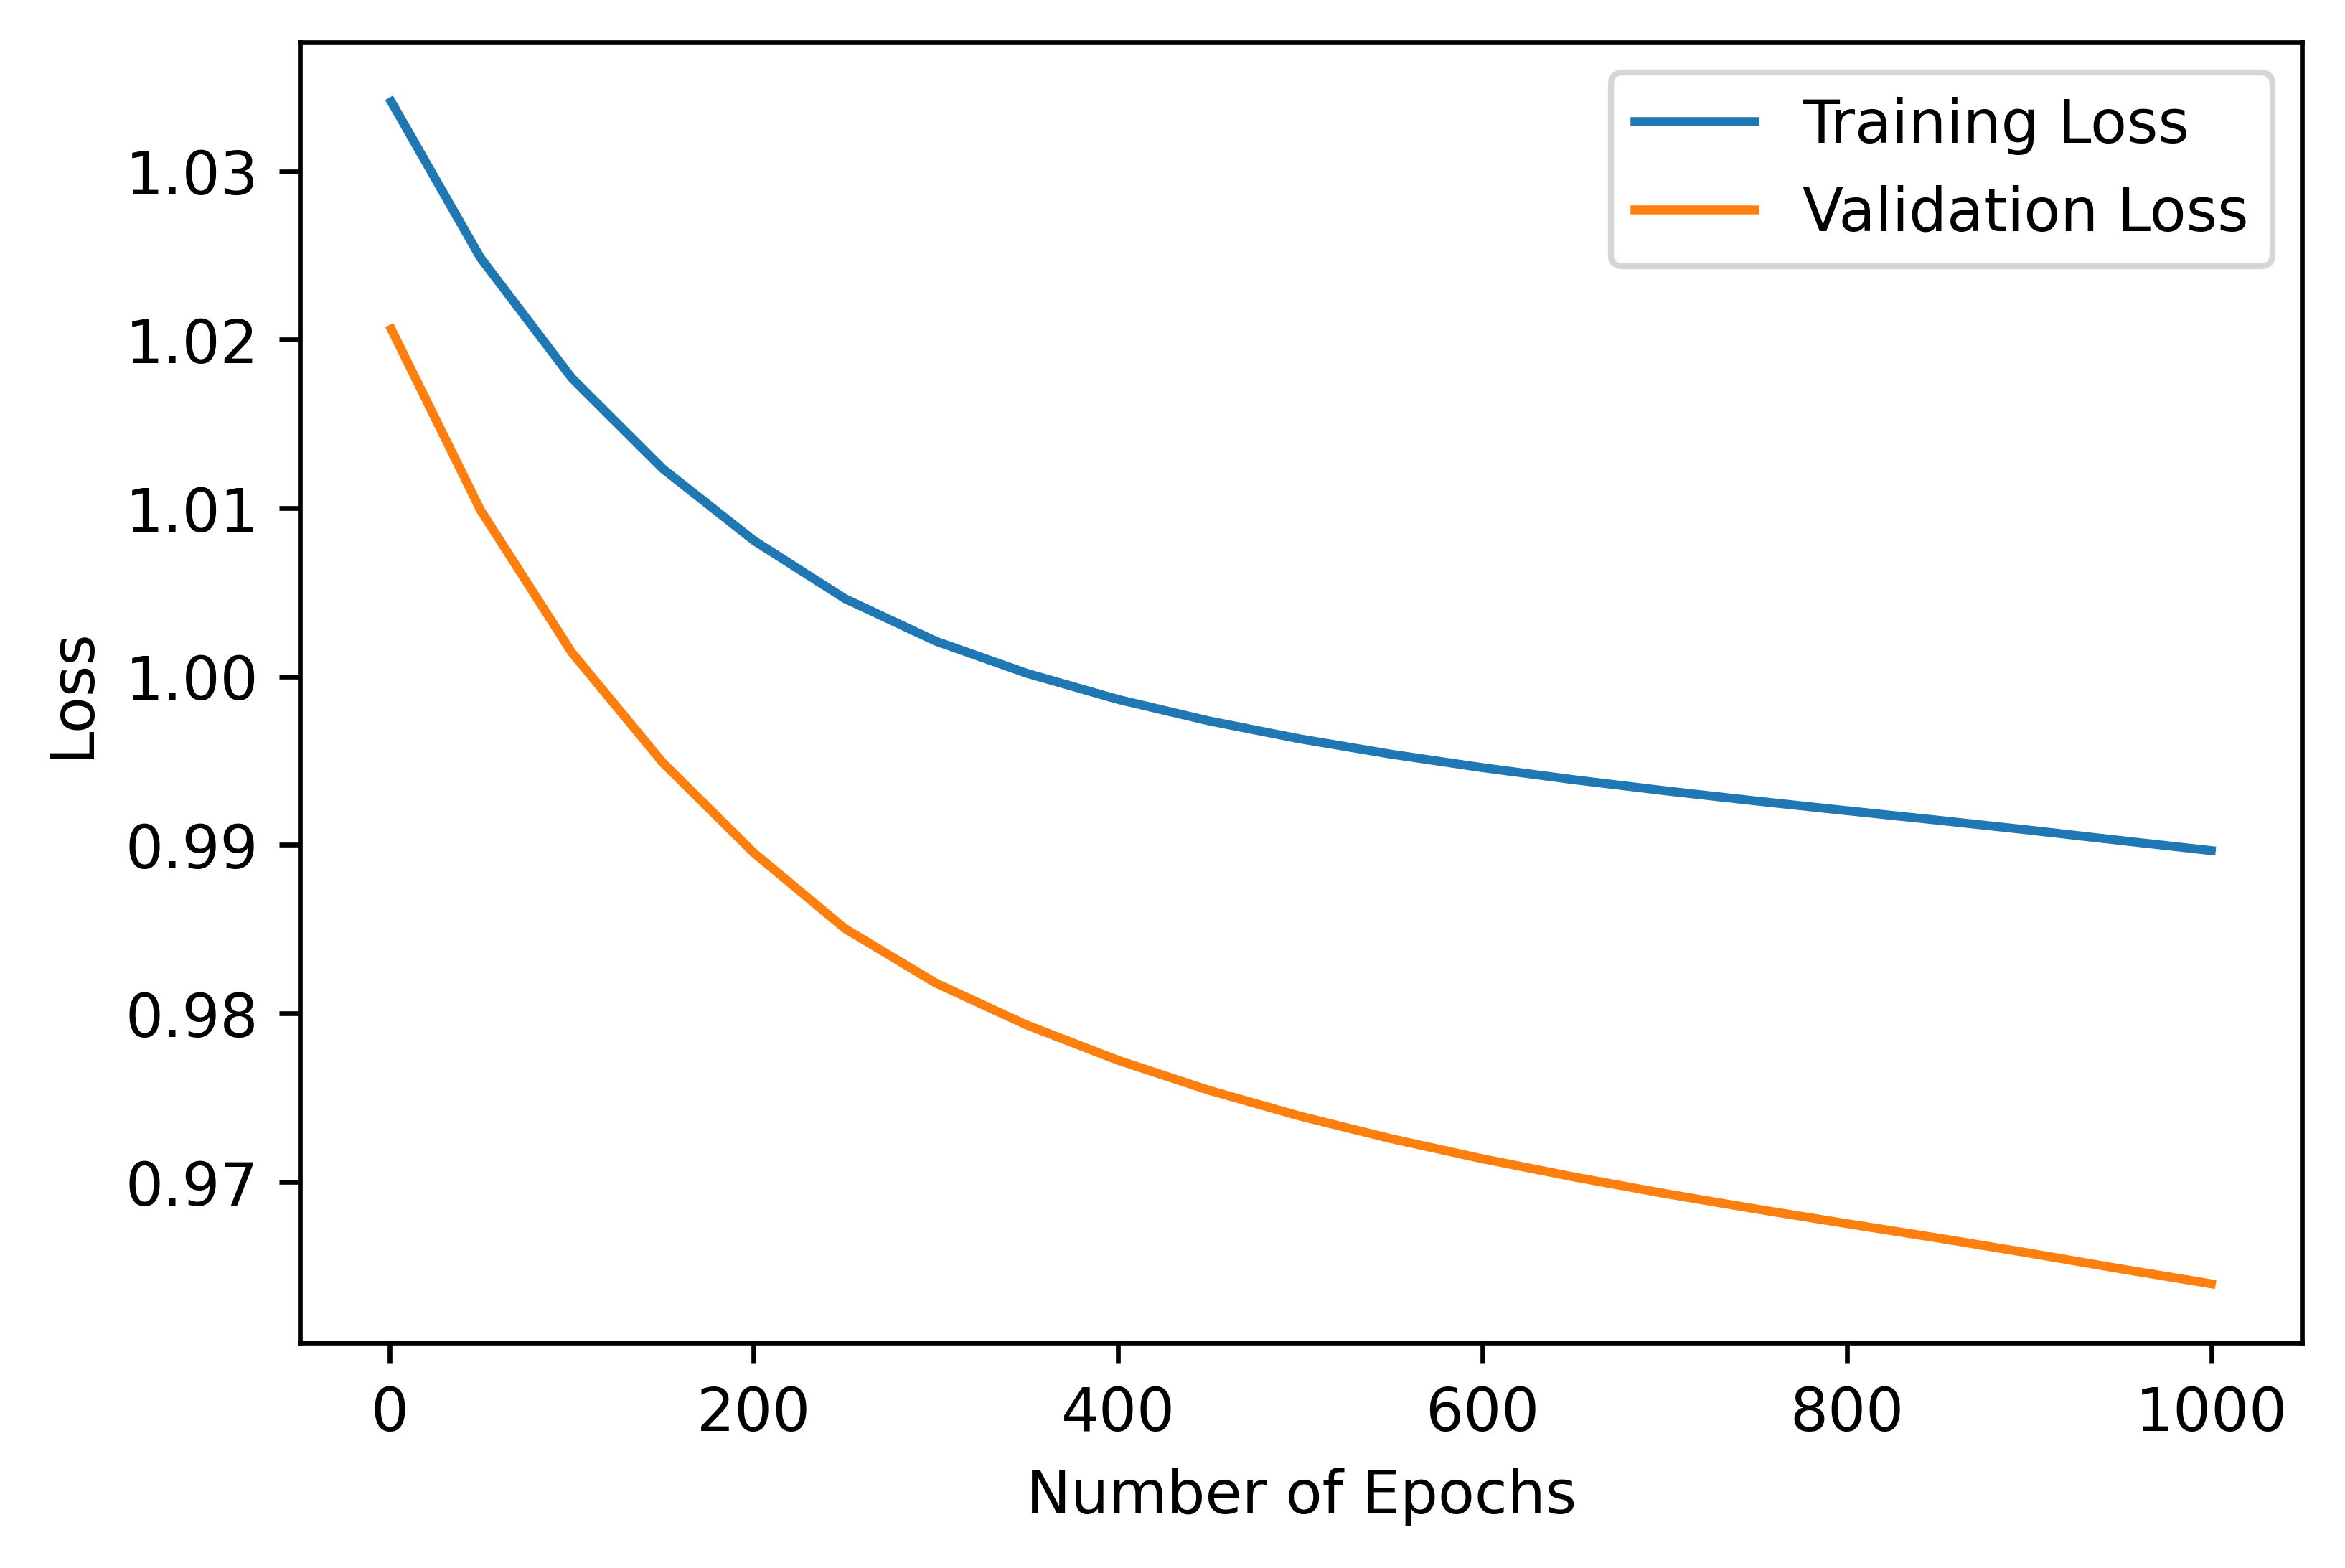

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.plot(epochs_list, loss_train_list, label="Training Loss")
plt.plot(epochs_list, loss_val_list, label="Validation Loss")
plt.legend()
plt.savefig("./loss_fun_5", format="png")

## Training a Time Series Model (LSTM)

In [59]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=6):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [60]:
from torch.utils.data import DataLoader

batch_size = 7
sequence_length = 24

# Filter dataset for features
target = "total load actual"
features = ["Average temperature in K", "Average pressure in hPa", \
           "Average humidity in %", "Average rain in last 1 hour in mm", \
           "Average rain in last 3 hours in mm", \
           "Average snow in last 3 hours in mm"]


train_dataset = SequenceDataset(
    df_train_data,
    target=target,
    features=features,
    sequence_length=sequence_length
)

val_dataset = SequenceDataset(
    df_val_data,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([7, 24, 6])
Target shape: torch.Size([7])


In [61]:
# Model
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out


In [62]:
learning_rate = 1e-5
num_hidden_units = 64

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [64]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def val_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
val_model(val_loader, model, loss_function)
print()

for epoch in range(200):
    if (epoch <= 3 or epoch % 50 == 0):
      print(f"Epoch {epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    val_model(val_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 1.0430840614949861

Epoch 0
---------
Train loss: 0.9611844842350905
Test loss: 0.8611365900644965

Epoch 1
---------
Train loss: 0.8477064071463154
Test loss: 0.707313151823901

Epoch 2
---------
Train loss: 0.7295569156891516
Test loss: 0.6629109654263737

Epoch 3
---------
Train loss: 0.6819683642700457
Test loss: 0.6318326077995291

Train loss: 0.6525679949507077
Test loss: 0.6126905682056419

Train loss: 0.6365807502168803
Test loss: 0.6025102019615086

Train loss: 0.6264504364830275
Test loss: 0.5956411246119909

Train loss: 0.6188906565910296
Test loss: 0.5894862901404189

Train loss: 0.6131318134239649
Test loss: 0.5860913719989514

Train loss: 0.6079121581870326
Test loss: 0.5816701206889091

Train loss: 0.6030275902868047
Test loss: 0.5792598463548432

Train loss: 0.5986059728313488
Test loss: 0.5761244110002465

Train loss: 0.5939796332167647
Test loss: 0.5720949806703995

Train loss: 0.5893283592386614
Test loss: 0.5691775225095296

Train 

In [51]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [52]:
ystar_col = "Model forecast"
df_train_data[ystar_col] = predict(train_eval_loader, model).numpy()
df_val_data[ystar_col] = predict(val_loader, model).numpy()

df_out = pd.concat((df_train_data, df_val_data))[[target, ystar_col]]

for c in df_out.columns:
    df_out[[str(c)]] = (df_out[[str(c)]] * target_std) + target_mean

print(df_out)

<ipython-input-52-f818e7686122>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                           total load actual  Model forecast
time                                                        
2015-01-01 00:00:00+01:00            25385.0    31213.408203
2015-01-01 01:00:00+01:00            24382.0    31213.480469
2015-01-01 02:00:00+01:00            22734.0    31237.367188
2015-01-01 03:00:00+01:00            21286.0    31250.292969
2015-01-01 04:00:00+01:00            20264.0    31259.820312
...                                      ...             ...
2018-12-31 19:00:00+01:00            30653.0    31239.634766
2018-12-31 20:00:00+01:00            29735.0    30609.488281
2018-12-31 21:00:00+01:00            28071.0    29755.458984
2018-12-31 22:00:00+01:00            25801.0    29091.537109
2018-12-31 23:00:00+01:00            24455.0    27280.716797

[38568 rows x 2 columns]


<ipython-input-52-f818e7686122>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
fig = px.line(df_out, labels=dict(created_at="Date", value="PM2.5 (ug/m3)"))
fig.add_vline(x="2017-12-14", line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()